# 以文搜图

事先将图片向量存入 Faiss。然后输入一条文本，取回该文本的 top k 相似图片。

```bash
# 启动嵌入生成服务
cd embedding; uvicorn server:app --port 8787

# 启动 Faiss 向量搜索服务
cd faiss; uvicorn server:app --port 8383
```

In [1]:
import os
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

import utils

from pathlib import Path
from PIL import Image

In [2]:
IMG_PATH = 'img'
BATCH_SIZE = 16

In [3]:
def chunk_list(lst, sz=BATCH_SIZE):
    return [lst[i:i + sz] for i in range(0, len(lst), sz)]

def process_data(func, lst, max_workers):
    res = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(func, lst)
        for result in results:
            res.append(result)
    return res

## 1. 将图片向量存入 Faiss

In [4]:
def get_image_paths(directory, extensions=['.jpg', '.jpeg', '.png', '.gif', '.bmp']):
    """获取指定目录下所有图片文件的路径"""
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

directory_path = utils.gen_abspath('./', IMG_PATH)
image_paths = get_image_paths(directory_path)

len(image_paths)

32

In [5]:
# 检查嵌入服务是否开启
ge = utils.GenEmbedding()
ge.test_home()

Index Response: {'app_name': 'embedding-server'}


In [6]:
# 生成所有图片的嵌入，如果数量较多，需要分 batch
# image_response = ge.get_remote_image_features(image_paths)
# image_features = image_response.get('image_features')

# 分 batch 多线程调用 FastAPI
chunked_list = chunk_list(image_paths)
image_responses = process_data(func=ge.get_remote_image_features,
                               lst=chunked_list,
                               max_workers=2)
image_features = [ee for e in image_responses for ee in e.get('image_features')]

np.array(image_features).shape

(32, 512)

In [7]:
# 测试向量搜索服务是否开启
fs = utils.FaissServer()
fs.test_home()

{'app_name': 'faiss-server'}

In [8]:
# 将图片向量灌入 Faiss
for img_fp, img_embd in zip(image_paths, image_features):
    fs.add_embedding(img_fp, img_embd)

fs.test_info()

{'total_vectors': 32}

## 2. 获取文本嵌入

In [9]:
# 获取文本嵌入
text_response = ge.get_remote_text_features(texts=['两眼一白'])
text_features = text_response.get('text_features')
np.array(text_features).shape

(1, 512)

## 3. 取回 top k 相似图片

In [10]:
# 用 Faiss 取回 top k 向量
search_response = fs.search_embedding(vector=text_features[0], top_k=3)
results = search_response.get('results')
for i, e in enumerate(results):
    print(f"distance {i}: {e.get('distance')}")

distance 0: 1.7813013792037964
distance 1: 1.783128023147583
distance 2: 1.7864981889724731


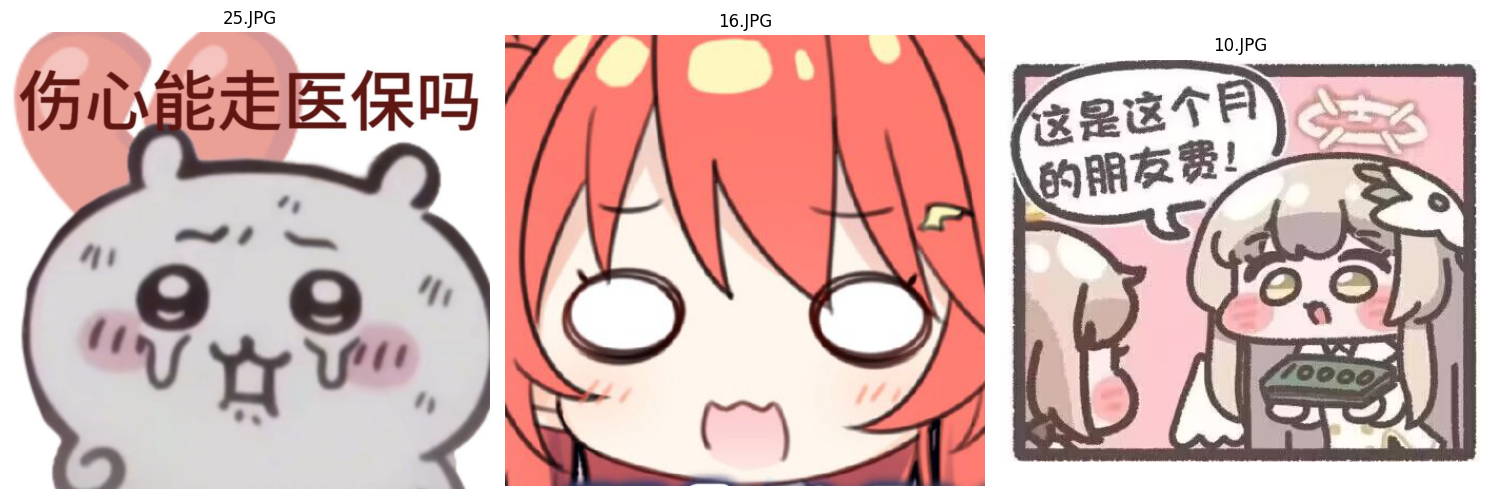

In [11]:
# 打印 top k 图片
search_paths = [e.get('id') for e in results]

# 创建一个子图，行数为 1，列数等于图片数量
num_images = len(search_paths)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# 只有一张图片时，axes 不是一个数组
if num_images == 1:
    axes = [axes]

for i, image_path in enumerate(search_paths):
    fn = Path(image_path)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(fn.name)
    axes[i].axis('off')

plt.tight_layout()  # 调整子图间距
plt.show()

## 4. 用 `get_similarity` 验证 Faiss 取回结果是否正确

index: 17


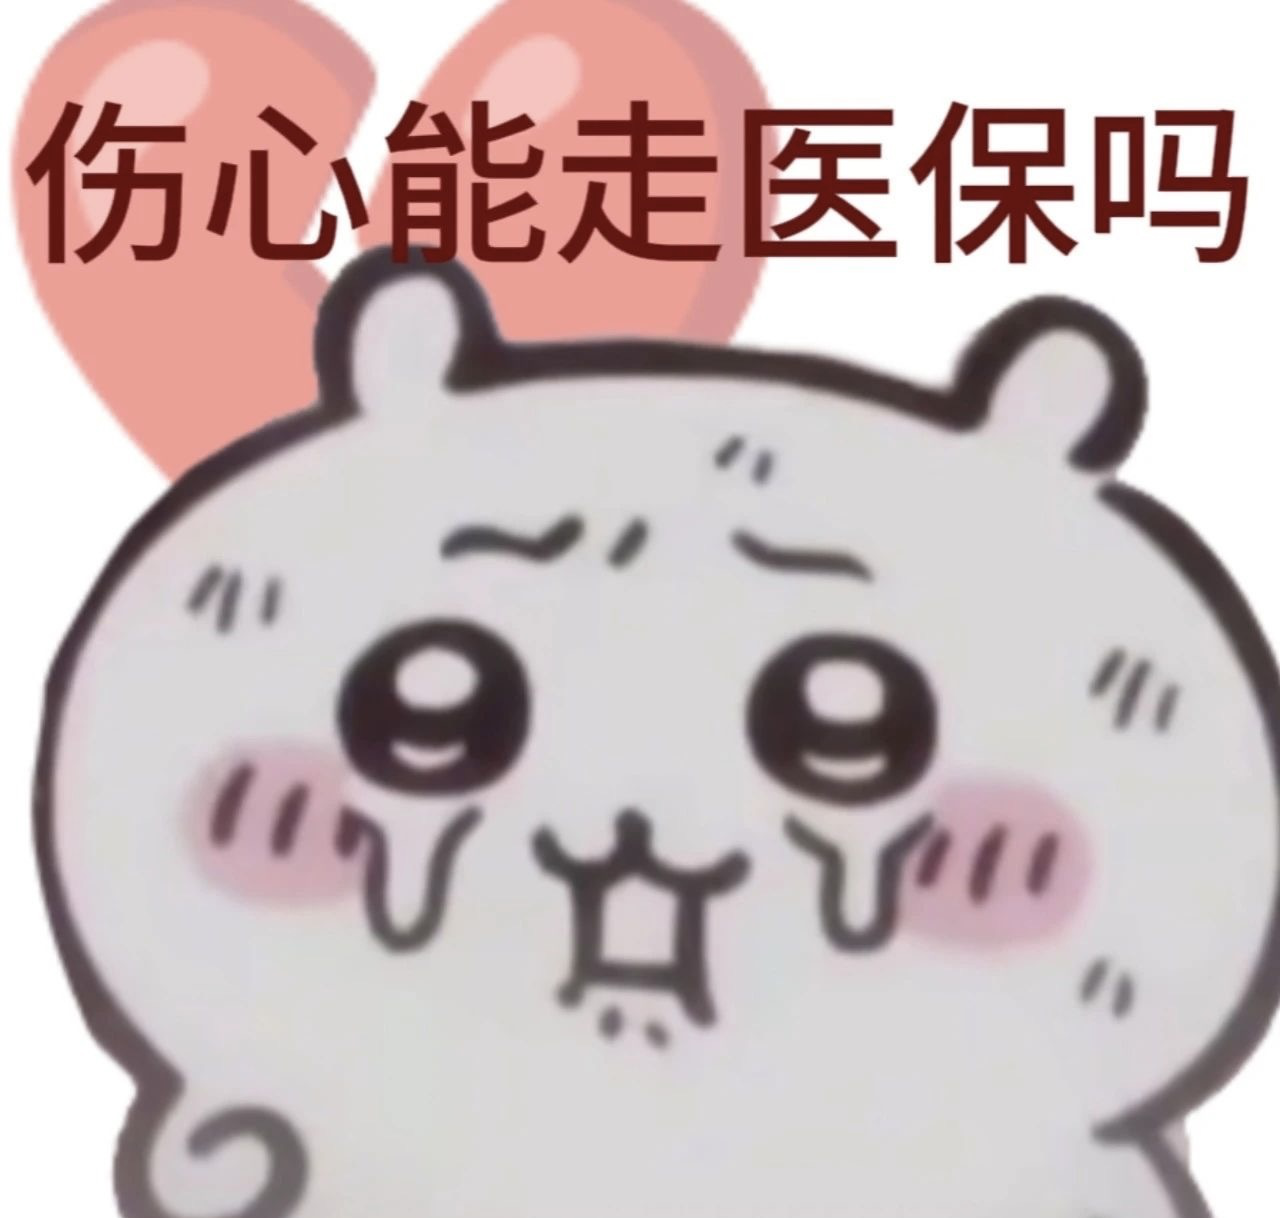

In [12]:
# 验证:用 get_similarity 函数找到最相似的图片
probs_response = ge.get_similarity(text_features, image_features)
probs_probs = probs_response.get('probs')
index = np.argmax(probs_probs)

print(f'index: {index}')

Image.open(image_paths[index])